In [1]:
# load normal libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import PolynomialFeatures, RobustScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.utils import check_random_state
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.preprocessing import QuantileTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.decomposition import PCA
from pyearth import Earth
np.warnings.filterwarnings('ignore')

from mlxtend.regressor import StackingCVRegressor

In [2]:
# import data

df = pd.read_csv('train.csv', nrows=90000, parse_dates=['pickup_datetime'], infer_datetime_format=True) 
target = 'fare_amount'

In [3]:
#check df
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 8 columns):
key                  90000 non-null object
fare_amount          90000 non-null float64
pickup_datetime      90000 non-null datetime64[ns]
pickup_longitude     90000 non-null float64
pickup_latitude      90000 non-null float64
dropoff_longitude    90000 non-null float64
dropoff_latitude     90000 non-null float64
passenger_count      90000 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 5.5+ MB


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1


In [4]:
# drop key
df.drop('key', axis=1, inplace=True)
df.head()


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1
1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1


In [5]:
#create distance traveled feature
df['distance'] = (np.abs(df['pickup_latitude'] - df['dropoff_latitude']) + np.abs(df['pickup_longitude'] - df['dropoff_longitude']))

In [6]:
# this function will also be used with the test set below
def select_within_boundingbox(df, BB):
    return (df.pickup_longitude >= BB[0]) & (df.pickup_longitude <= BB[1]) & \
           (df.pickup_latitude >= BB[2]) & (df.pickup_latitude <= BB[3]) & \
           (df.dropoff_longitude >= BB[0]) & (df.dropoff_longitude <= BB[1]) & \
           (df.dropoff_latitude >= BB[2]) & (df.dropoff_latitude <= BB[3])
            
# load image of NYC map
BB = (-74.5, -72.8, 40.5, 41.8)

In [7]:


print('Old size: %d' % len(df))
df = df[select_within_boundingbox(df, BB)]
print('New size: %d' % len(df))



Old size: 90000
New size: 88091


In [8]:
#remove fares rows with fares less than 1 and filter long lats
df = df[(df.fare_amount > 1) & (df.fare_amount < 52)]
# df = df[(df.pickup_longitude >= low_long) & (df.pickup_longitude <= high_long)]


In [9]:
df['time'] = pd.DatetimeIndex(df['pickup_datetime']).hour

In [10]:
df['year'] = pd.DatetimeIndex(df['pickup_datetime']).year

In [11]:
df['day'] = df['pickup_datetime'].dt.dayofweek

In [12]:
df['is_weekend'] = (df['day'] >= 5).astype(np.int)

In [13]:
df.drop('pickup_datetime', axis=1, inplace=True)

In [14]:
# define used cols
used_cols = [c for c in df.columns.tolist() if c not in target]
# used_cols = ['distance', 'day', 'time', 'year']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87063 entries, 0 to 89999
Data columns (total 11 columns):
fare_amount          87063 non-null float64
pickup_longitude     87063 non-null float64
pickup_latitude      87063 non-null float64
dropoff_longitude    87063 non-null float64
dropoff_latitude     87063 non-null float64
passenger_count      87063 non-null int64
distance             87063 non-null float64
time                 87063 non-null int64
year                 87063 non-null int64
day                  87063 non-null int64
is_weekend           87063 non-null int64
dtypes: float64(6), int64(5)
memory usage: 8.0 MB


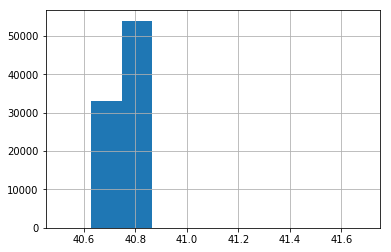

In [15]:
df['pickup_latitude'].hist()

In [16]:
# pd.plotting.scatter_matrix(df,n_jobs=-1)

In [17]:

df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,time,year,day,is_weekend
count,87063.000000,87063.000000,87063.000000,87063.000000,87063.000000,87063.000000,87063.000000,87063.000000,87063.000000,87063.00000,87063.000000
mean,10.743687,-73.975985,40.751684,-73.974438,40.752049,1.672858,0.041803,13.494332,2011.725245,3.03471,0.282910
std,7.836605,0.036000,0.028959,0.034692,0.032075,1.299141,0.047573,6.514805,1.866494,1.95123,0.450416
min,2.500000,-74.356127,40.509960,-74.339372,40.505648,0.000000,0.000000,0.000000,2009.000000,0.00000,0.000000
25%,6.000000,-73.992278,40.736940,-73.991377,40.736240,1.000000,0.016310,9.000000,2010.000000,1.00000,0.000000
50%,8.500000,-73.982132,40.753661,-73.980479,40.754186,1.000000,0.027849,14.000000,2012.000000,3.00000,0.000000
75%,12.500000,-73.968592,40.767804,-73.965417,40.768617,2.000000,0.049944,19.000000,2013.000000,5.00000,1.000000
max,51.830000,-72.856968,41.692428,-72.854940,41.714633,6.000000,1.537858,23.000000,2015.000000,6.00000,1.000000


In [18]:
# for i in used_cols:
#     sns.regplot(x=i, y=target, data=df)
#     sns.jointplot(x=i, y=target, data=df)
#     plt.show()

In [19]:
#transforming target and distance
# df['log_target'] = np.log1p(df['fare_amount'])
target = 'fare_amount'
df['log_distance'] = np.log1p(df['distance'])
df

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,time,year,day,is_weekend,log_distance
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,0.011742,17,2009,0,0,0.011674
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,0.107481,16,2010,1,0,0.102088
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,0.019212,0,2011,3,0,0.019030
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,0.029386,4,2012,5,1,0.028963
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,0.027194,7,2010,1,0,0.026831
...,...,...,...,...,...,...,...,...,...,...,...,...
89994,8.5,-74.008082,40.712126,-73.987247,40.750575,3,0.059284,1,2012,4,0,0.057593
89995,6.0,-73.981823,40.755288,-73.971944,40.760342,1,0.014933,21,2014,4,0,0.014823
89997,6.9,-73.958400,40.800849,-73.953479,40.820304,1,0.024376,4,2010,6,1,0.024084
89998,4.0,-73.974650,40.755904,-73.969536,40.758718,1,0.007928,9,2013,2,0,0.007897


In [20]:
criteon = ('rss', 'nb_subsets')
lr = LinearRegression(n_jobs=-1)
poly = PolynomialFeatures(degree=2)
scaler = RobustScaler()
lor = LogisticRegression()
Ridge = linear_model.BayesianRidge(compute_score=True)
lasso = linear_model.Lasso()
mars = Earth(max_degree=4, feature_importance_type=criteon)
pipe = make_pipeline(scaler, mars)


# scores = cross_val_score(pipe, df[used_cols], df[target], cv=5, scoring='r2')
# scores = cross_val_score(pipe, df[used_cols], df[target], cv=5, scoring='neg_mean_absolute_error')
# scores = cross_val_score(pipe, df[used_cols], df[target], cv=5, scoring='neg_mean_squared_error')
# print(np.sqrt(-scores.mean()), "+/-", np.sqrt(scores.std()))
X, y = df[used_cols], df[target]
# X = df[used_cols]

In [21]:
SIZE = (20,8)


def analysis(pipe):
    scores = cross_val_score(pipe, X, y, cv=5)
    print()
    print("\tR^2:", scores.mean(), " +/- ", scores.std())

    scores = cross_val_score(pipe, X, y, cv=5, scoring='neg_mean_squared_error')
    print("\tRMSE:", np.sqrt(-scores.mean()), " +/- ", np.sqrt(scores.std()))
    print()

    y_pred = cross_val_predict(pipe, X, y, cv=5)

#     plt.figure(figsize=SIZE)
#     sns.scatterplot(y_pred, (y - y_pred))
#     sns.lineplot(y_pred, [0]*len(y_pred), color='orange')
#     plt.xlabel("Predicted")
#     plt.ylabel("Residual")
#     plt.show()
    
#     plt.figure(figsize=SIZE)
#     plt.hist(y - y_pred, bins=20)
#     plt.show()

    
def run_test(model):
    scale = RobustScaler()
    
    tags = ["", " w/ Poly (deg 2)"]
    
    for tag in tags:
        if tag == "":
            pipe = make_pipeline(scale, model)
        elif "2" in tag:
            poly = PolynomialFeatures(2)
            pipe = make_pipeline(poly, scale, model)
    
        try:
            print("Vanilla"+tag+":")
            analysis(pipe)
        except:
            pass

        try:
            print("Target-Normalized"+tag+":")
            transformer = QuantileTransformer(n_quantiles=20, output_distribution='normal')
            tpipe = TransformedTargetRegressor(regressor=pipe,
                                               transformer=transformer)
            analysis(tpipe)
        except:
            pass
        
        try:
            print("Target-Logged"+tag+":")
            tpipe = TransformedTargetRegressor(regressor=pipe,
                                               func=np.log1p, 
                                               inverse_func=np.expm1)
            analysis(tpipe)
        except:
            pass

In [22]:

# run_test(mars)

In [23]:
print(mars.summary_feature_importances())

AttributeError: 'Earth' object has no attribute '_feature_importances_dict'

In [ ]:
df

In [ ]:
df['is_weekend'] = (df['day'] >= 5).astype(np.int)

In [ ]:
df

In [ ]:
df.describe()

In [ ]:
lr

In [ ]:
# pipe.fit(X,y)

In [ ]:
pipe.get_params()

In [27]:
df_test = pd.read_csv('test.csv', parse_dates=['pickup_datetime'], infer_datetime_format=True) 


In [28]:
# df_test.drop('key', axis=1, inplace=True)
df_test['distance'] = (np.abs(df_test['pickup_latitude'] - df_test['dropoff_latitude']) + np.abs(df_test['pickup_longitude'] - df_test['dropoff_longitude']))


In [29]:
df_test['time'] = pd.DatetimeIndex(df_test['pickup_datetime']).hour

In [30]:
df_test['year'] = pd.DatetimeIndex(df_test['pickup_datetime']).year

In [31]:
df_test['day'] = df_test['pickup_datetime'].dt.dayofweek

In [ ]:
# df_test['log_distance'] = np.log1p(df_test['distance'])


In [34]:
df_test['is_weekend'] = (df_test['day'] >= 5).astype(np.int)

In [32]:

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87063 entries, 0 to 89999
Data columns (total 12 columns):
fare_amount          87063 non-null float64
pickup_longitude     87063 non-null float64
pickup_latitude      87063 non-null float64
dropoff_longitude    87063 non-null float64
dropoff_latitude     87063 non-null float64
passenger_count      87063 non-null int64
distance             87063 non-null float64
time                 87063 non-null int64
year                 87063 non-null int64
day                  87063 non-null int64
is_weekend           87063 non-null int64
log_distance         87063 non-null float64
dtypes: float64(7), int64(5)
memory usage: 8.6 MB


In [35]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 12 columns):
key                  9914 non-null object
pickup_datetime      9914 non-null datetime64[ns]
pickup_longitude     9914 non-null float64
pickup_latitude      9914 non-null float64
dropoff_longitude    9914 non-null float64
dropoff_latitude     9914 non-null float64
passenger_count      9914 non-null int64
distance             9914 non-null float64
time                 9914 non-null int64
year                 9914 non-null int64
day                  9914 non-null int64
is_weekend           9914 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(5), object(1)
memory usage: 929.6+ KB


In [36]:
y_preds = mars.predict(df_test[used_cols])

In [37]:
y_preds

array([ 9.72741874, 11.09680737,  4.86731739, ..., 45.6676505 ,
       23.18340736,  7.47714743])

In [38]:
df_sub = pd.DataFrame(df_test['key'])


In [39]:
y_preds = pd.DataFrame(y_preds)

In [40]:
y_preds

,0
0,9.727419
1,11.096807
2,4.867317
3,8.139590
4,14.986630
...,...
9909,9.594972
9910,12.453585
9911,45.667651
9912,23.183407


In [41]:
df_sub['fare_amount'] = y_preds

In [42]:
# df_sub.drop('fare_amount', axis=0, inplace=True)

In [43]:
df_sub.tail()

,key,fare_amount
9909,2015-05-10 12:37:51.0000002,9.594972
9910,2015-01-12 17:05:51.0000001,12.453585
9911,2015-04-19 20:44:15.0000001,45.667651
9912,2015-01-31 01:05:19.0000005,23.183407
9913,2015-01-18 14:06:23.0000006,7.477147


In [44]:
df_sub.to_csv('submission1.csv', index=False)

In [ ]:
df_sub.shape

In [ ]:
X

In [26]:
mars.fit(X,y)

Earth(allow_linear=None, allow_missing=False, check_every=None,
      enable_pruning=True, endspan=None, endspan_alpha=None, fast_K=None,
      fast_h=None, feature_importance_type=('rss', 'nb_subsets'), max_degree=4,
      max_terms=None, min_search_points=None, minspan=None, minspan_alpha=None,
      penalty=None, smooth=None, thresh=None, use_fast=None, verbose=0,
      zero_tol=None)

In [33]:
print(mars.trace())
print(mars.summary())
print(mars.summary_feature_importances(sort_by='nb_subsets'))
mars.feature_importances_

Forward Pass
------------------------------------------------------------------
iter  parent  var  knot   mse        terms  gcv     rsq    grsq   
------------------------------------------------------------------
0     -       -    -      61.411670  1      61.413  0.000  0.000  
1     0       5    32015  15.880254  3      15.882  0.741  0.741  
2     2       5    57958  15.151306  5      15.155  0.753  0.753  
3     3       7    -1     14.003851  6      14.008  0.772  0.772  
4     5       0    17514  13.681466  8      13.687  0.777  0.777  
5     0       3    58379  13.413532  10     13.421  0.782  0.781  
6     3       5    43710  13.223363  12     13.232  0.785  0.785  
7     5       2    41391  13.079385  14     13.089  0.787  0.787  
8     3       0    55018  12.908350  16     12.920  0.790  0.790  
9     15      2    30423  12.592462  18     12.605  0.795  0.795  
10    8       1    54615  12.489539  20     12.503  0.797  0.796  
11    14      2    3854   12.379022  22     12.39

{'rss': array([0.01404648, 0.01039164, 0.0136579 , 0.01114222, 0.        ,
        0.94745045, 0.        , 0.0033113 , 0.        , 0.        ]),
 'nb_subsets': array([0.19607843, 0.07843137, 0.11764706, 0.09803922, 0.        ,
        0.41176471, 0.        , 0.09803922, 0.        , 0.        ])}